<a href="https://colab.research.google.com/github/GarethWilhelm/TS-Feature-Clustering/blob/Feature-clustering-ZAF/Time-series_Feature_Clustering_%20SA_Steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configs

## Required packages

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
Cloning into 'automations'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 293 (delta 26), reused 29 (delta 12), pack-reused 247
Receiving objects: 100% (293/293), 45.56 KiB | 2.17 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Already up to date.


In [2]:
# !pip install -q oec
# import oec
!pip install -U -q yellowbrick
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

     |████████████████████████████████| 276kB 3.4MB/s 


## Load data

## Data processing

### Lists

In [3]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_',
                      'index_mass_quantile','__attr_intercept','__attr_stderr',
                      'sum_values','sum_values','has_duplicate','length','quantile',
                      'ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks',
                      'reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring',
                      'symmetry_looking','variation','longest_strike_','energy_ratio_by_chunks',
                      'variance_larger_than_standard_deviation','__lag_0','fourier_entropy',
                      'friedrich_coefficients','bins_100','correlation', 'augmented','entropy','ar_coefficient']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values',
             'maximum','length','minimum', 'lag', 'peaks', 'location', 'lempel', 'autolag', 'coefficients']
stats = ['kurtosis','^median$','linear_trend', 'standard_deviation', 'skewness', 'period']
stationarity = ['energy','komolgorov','sample']

### Data preparation

In [27]:
experiment = "stationary_entropy"
PATH = '/content/drive/My Drive/Stellenbosch/Gareth/sitc/year_origin_sitc_rev2.tsv'
all_eff_features = pd.read_excel(f'{PATH}/cluster1_features_extracted.xlsx')\
 .rename(columns = {'Unnamed: 0': 'product_code'}, inplace = False)
all_eff_features.set_index('product_code',inplace=True)


In [28]:
features_filtered = change_column_prefix(
     remove_features_df(all_eff_features,filter_features(all_eff_features,redundant_features)))
features_filtered.columns

Index(['abs_energy', 'mean_abs_change', 'mean_change',
       'mean_second_derivative_central', 'median', 'mean',
       'standard_deviation', 'variance', 'skewness', 'kurtosis',
       'absolute_sum_of_changes', 'first_location_of_maximum',
       'first_location_of_minimum', 'maximum', 'minimum', 'c3__lag_1',
       'c3__lag_2', 'c3__lag_3', 'cid_ce__normalize_True',
       'cid_ce__normalize_False', 'number_peaks__n_1', 'number_peaks__n_3',
       'number_peaks__n_5', 'number_peaks__n_10', 'number_peaks__n_50',
       'linear_trend__attr_"pvalue"', 'linear_trend__attr_"rvalue"',
       'linear_trend__attr_"intercept"', 'linear_trend__attr_"slope"',
       'linear_trend__attr_"stderr"', 'lempel_ziv_complexity__bins_2',
       'lempel_ziv_complexity__bins_3', 'lempel_ziv_complexity__bins_5',
       'lempel_ziv_complexity__bins_10'],
      dtype='object')

# Run the ETL

In [29]:
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df.columns

Index(['abs_energy'], dtype='object')

In [30]:
# stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.columns = (stationary_features_df.columns.str.strip().\
                                  str.replace('__tau_1','').\
                                  str.replace('coefficient__','').\
                                  str.replace('complexity__','').\
                                  str.replace('__k_10','').\
                                  str.replace('__max_bins_10','').\
                                  str.replace('__autolag','')
                                  )
simplify_column_name(stationary_features_df,'permutation_entropy__dimension','permutation_entropy')
clean_header(stationary_features_df)
# Drop correlated features (threshold: 0.5)
stationary_features_df = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
stationary_features_df.columns

Index([], dtype='object')

In [31]:
stationary_features_df = remove_outliers_iqr(stationary_features_df)
stationary_features_df.reset_index() 

,product_code
0,zaf6712
1,zaf6727
2,zaf6731
3,zaf6732
4,zaf6733
...,...
132,zaf7932
133,zaf8121
134,zaf8124
135,zaf8941


In [33]:
# Add statistical features to dataframe
stats_features_df = features_filtered[filter_features(features_filtered,stats)]
stats_features_df = remove_outliers_iqr(stats_features_df)
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('__autolag_aic', ''))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('kurtosis', 'kurtosis'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('median','median'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('linear_trend__attr', 'trend'))
stats_features_df.reset_index() 

,product_code,kurtosis,median,"trend_""pvalue""","trend_""rvalue""","trend_""intercept""","trend_""slope""","trend_""stderr""",standard_deviation,skewness
0,zaf6712,1.214255,44304021.00,2.793592e-12,0.773485,-3.308522e+07,4.252455e+06,4.741904e+05,8.886195e+07,1.490145
1,zaf6727,-0.100012,79104645.50,5.004884e-15,0.833824,-1.632100e+08,1.582390e+07,1.452782e+06,2.957794e+08,1.023473
2,zaf6731,-0.314107,38068251.50,6.904645e-11,0.749669,-7.779462e+06,2.228003e+06,2.727593e+05,4.632066e+07,0.797045
3,zaf6732,-0.730077,65093403.25,1.678621e-18,0.873307,-1.506883e+07,3.003327e+06,2.279921e+05,5.558581e+07,0.528004
4,zaf6733,-1.224862,72596938.00,8.146140e-11,0.738620,3.316730e+06,2.670789e+06,3.317114e+05,5.844492e+07,0.236706
...,...,...,...,...,...,...,...,...,...,...
132,zaf7932,0.571846,7910000.00,2.759839e-13,0.798668,-2.560410e+07,2.213648e+06,2.291056e+05,4.399895e+07,1.257642
133,zaf8121,0.867695,1210042.00,2.733206e-12,0.811181,-1.738373e+06,1.763248e+05,1.874220e+04,3.011286e+06,1.340888
134,zaf8124,2.188511,2220533.00,2.387422e-12,0.774973,-1.226456e+07,8.906512e+05,9.884099e+04,1.857587e+07,1.790283
135,zaf8941,2.730361,87379.00,7.830128e-11,0.783025,-2.587232e+05,2.382723e+04,2.821473e+03,4.127690e+05,1.836649


In [35]:
# Merge stationarity and statistical features
features_uncorrelated = pd.merge(stationary_features_df,stats_features_df,on='product_code')
clean_header(features_uncorrelated)

,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
product_code,,,,,,,,,
zaf6712,1.214255,44304021.00,2.793592e-12,0.773485,-3.308522e+07,4.252455e+06,4.741904e+05,8.886195e+07,1.490145
zaf6727,-0.100012,79104645.50,5.004884e-15,0.833824,-1.632100e+08,1.582390e+07,1.452782e+06,2.957794e+08,1.023473
zaf6731,-0.314107,38068251.50,6.904645e-11,0.749669,-7.779462e+06,2.228003e+06,2.727593e+05,4.632066e+07,0.797045
zaf6732,-0.730077,65093403.25,1.678621e-18,0.873307,-1.506883e+07,3.003327e+06,2.279921e+05,5.558581e+07,0.528004
zaf6733,-1.224862,72596938.00,8.146140e-11,0.738620,3.316730e+06,2.670789e+06,3.317114e+05,5.844492e+07,0.236706
...,...,...,...,...,...,...,...,...,...
zaf7932,0.571846,7910000.00,2.759839e-13,0.798668,-2.560410e+07,2.213648e+06,2.291056e+05,4.399895e+07,1.257642
zaf8121,0.867695,1210042.00,2.733206e-12,0.811181,-1.738373e+06,1.763248e+05,1.874220e+04,3.011286e+06,1.340888
zaf8124,2.188511,2220533.00,2.387422e-12,0.774973,-1.226456e+07,8.906512e+05,9.884099e+04,1.857587e+07,1.790283


In [36]:
features_uncorrelated.fillna(0,inplace=True)
features_uncorrelated.isnull().sum()

kurtosis              0
median                0
trend_pvalue          0
trend_rvalue          0
trend_intercept       0
trend_slope           0
trend_stderr          0
standard_deviation    0
skewness              0
dtype: int64

## EDA and correlation analysis

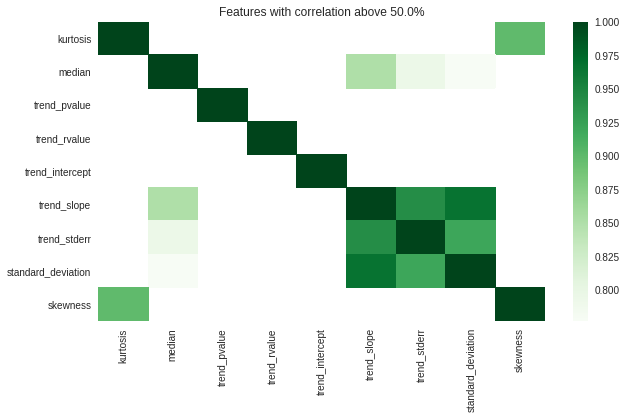

In [37]:
image_dump = f"{PATH}/images"
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{image_dump}/_correlation_{experiment} for cluster 3 steel-related products")
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series

# Clustering

## PCA + k-Means

* Scale features using Standard Scaler
* Dimension reduction to 2 PCs
* Locate optimum number of cluster

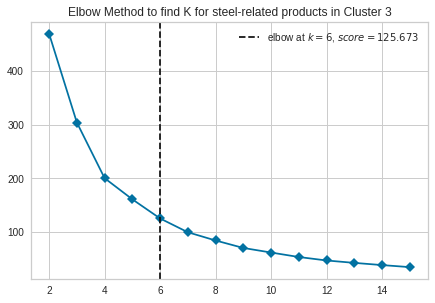

In [38]:
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)
product_name = 'all_products'
# Reduce dimensions using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)

# Optimum clusters
# plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),15)
kelbow_visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=15,metric='distortion',
    timings=False,locate_elbow=True,size=(512, 340))
kelbow_visualizer.fit(np.asarray(PCA_components))
pca_k_value = kelbow_visualizer.elbow_value_
plt.title('Elbow Method to find K for steel-related products in Cluster 3')
plt.legend()
plt.savefig(f"{image_dump}/{experiment}_elbow for Cluster 3 steel-related products")

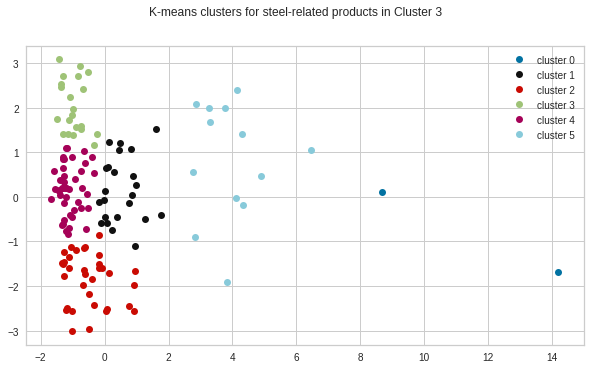

In [40]:
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),pca_k_value,f"steel-related products in Cluster 3",
                                                      f"{image_dump}")



In [41]:
#features_uncorrelated['product_code'].astype(str)
features_uncorrelated.index

Index(['zaf6712', 'zaf6727', 'zaf6731', 'zaf6732', 'zaf6733', 'zaf6744',
       'zaf6746', 'zaf6747', 'zaf6749', 'zaf6760',
       ...
       'zaf7853', 'zaf7861', 'zaf7868', 'zaf7919', 'zaf7929', 'zaf7932',
       'zaf8121', 'zaf8124', 'zaf8941', 'zaf8951'],
      dtype='object', name='product_code', length=137)

In [42]:
details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'product_code':'names'})
get_names.names.astype('str')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
country_cluster.head()
country_cluster.to_csv(f'/{PATH}/assigned_clusters_for_cluster_3_products.csv')


In [43]:
groups = country_cluster.groupby(['cluster']).agg('mean')


In [44]:
#clust = groups.reset_index()
dict_clust = {0:'cluster_0',
              1: 'cluster_1',
              2: 'cluster_2',
              3: 'cluster_3',
              4: 'cluster_4',
              5: 'cluster_5'
              }
clust = groups.reset_index()
clust.replace({'cluster': dict_clust},inplace=True)
clust.set_index('cluster',inplace=True)
# x = clust.iloc[-1,:]
clust

,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
cluster,,,,,,,,,
cluster_0,-0.601562,5.479488,-0.170686,0.645808,-4.881964,5.480967,4.371393,5.358131,-0.488357
cluster_1,0.007913,0.058918,-0.151148,0.092398,-0.237088,0.255039,0.309901,0.240716,0.224817
cluster_2,-1.146959,0.006270,-0.170663,0.731667,0.359953,-0.242057,-0.329302,-0.308717,-1.211177
cluster_3,1.525390,-0.465407,-0.169079,-0.283640,0.275643,-0.473000,-0.499408,-0.409808,1.391063
cluster_4,0.055856,-0.395960,0.346165,-0.480292,0.456785,-0.509135,-0.491999,-0.495650,0.027156
cluster_5,0.425142,1.128349,-0.158484,-0.092630,-1.762191,1.825927,2.112406,1.896787,0.506055


In [45]:
b = clust.T

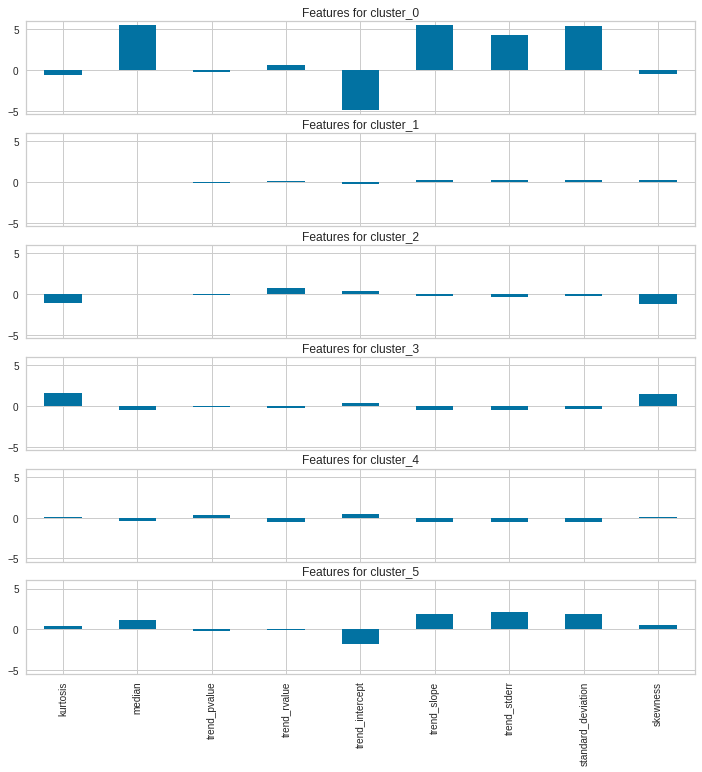

In [47]:
n = len(b.columns)
fig, ax = plt.subplots(n, 1, figsize=(12, n * 2), sharex=True,sharey=True)
for i in range(n):
    plt.sca(ax[i])
    col = b.columns[i]
    b[col].plot(kind='bar')
    plt.title(f"Features for {col}")
    # plt.tight_layout()
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features_cluster_3.png",bbox_inches = "tight")

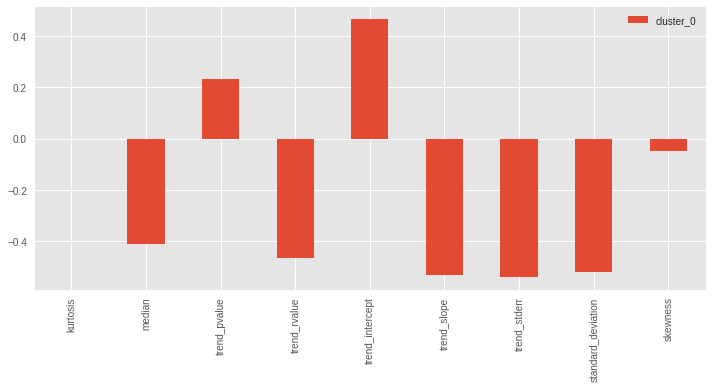

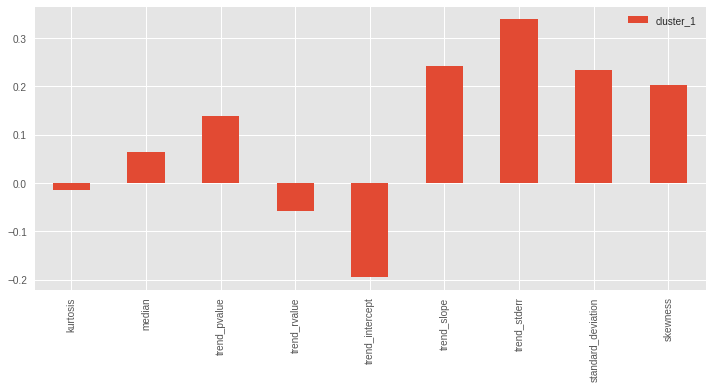

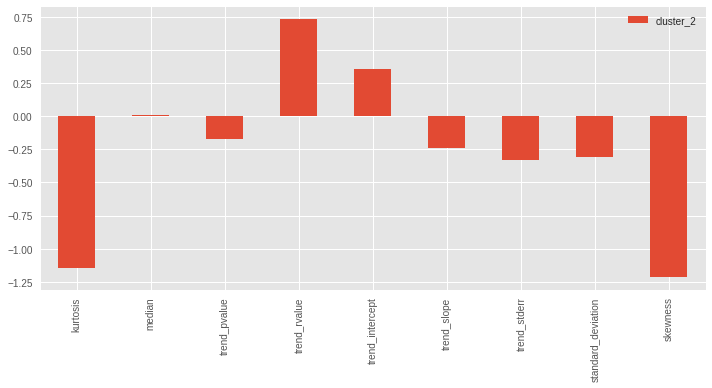

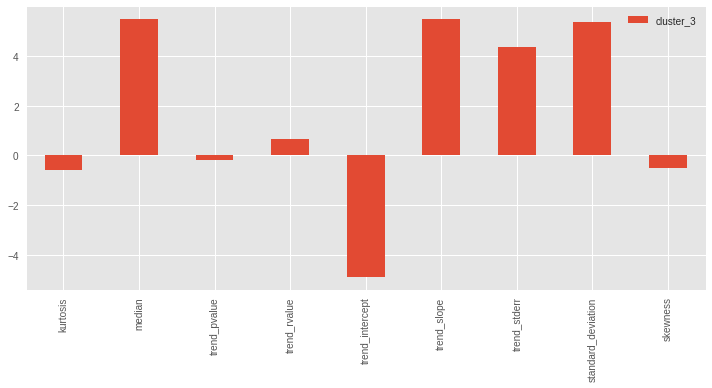

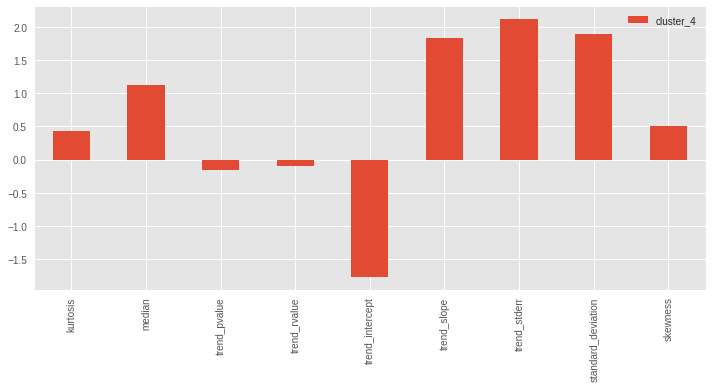

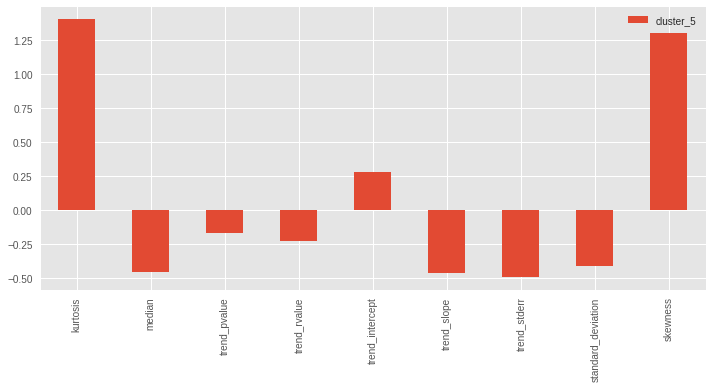

In [290]:
# AR0-1-2-3, autoregressive coeff. Tells you whethere the ts fits an autoregressive model.
# AR1 shows fits auto reg model of order 1 etc...
# aug dicky fuller, tells whether or not ts has a unit root - tells whether ts is stationary- stationary means behaviour doesnt change, almost determines predictability or not
# kurtosis - sensitivity to outlier
# permu entropy - exclude - entropy used in place of shannon entropy
for col in b.columns:
  b[col].plot(kind='bar',figsize=(10,5.5))
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"{image_dump}/{col}_{product_name}_features.png",bbox_inches = "tight")
  plt.show()

# Cluster analysis

In [291]:
trade_dframe = pd.read_excel(f'{PATH}/zaf_df.xlsx', usecols=['year', 'export_val', 'zaf_code'])
trade_dframe.head()


,year,export_val,zaf_code
0,1962,42000.0,zaf6289
1,1962,2000.0,zaf6352
2,1962,8000.0,zaf6577
3,1962,290000.0,zaf6731
4,1962,6000.0,zaf6760


In [292]:
country_cluster.head()

,names,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness,cluster
0,zaf6712,0.981112,0.873311,-0.170686,-0.442703,-0.538989,0.572455,0.656682,1.023029,1.087596,1
1,zaf6727,-0.375007,1.990595,-0.170686,0.267902,-4.868117,3.951477,3.458618,4.956224,-0.097176,3
2,zaf6731,-0.595921,0.673110,-0.170686,-0.723183,0.302910,-0.018713,0.079937,0.214382,-0.672026,1
3,zaf6732,-1.025138,1.540760,-0.170686,0.732890,0.060400,0.207692,-0.048242,0.390498,-1.355059,2
4,zaf6733,-1.535679,1.781664,-0.170686,-0.853311,0.672070,0.110586,0.248731,0.444846,-2.094599,2


<Figure size 720x396 with 0 Axes>

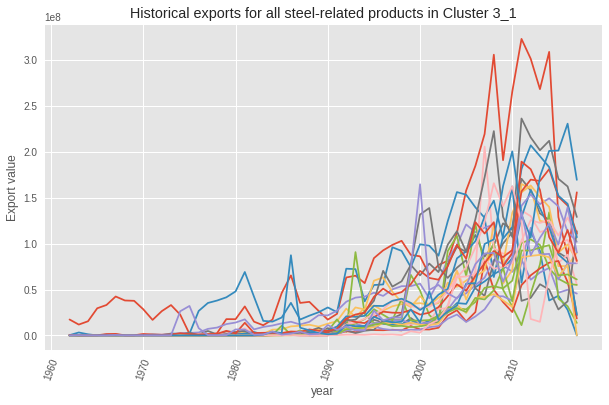

<Figure size 720x396 with 0 Axes>

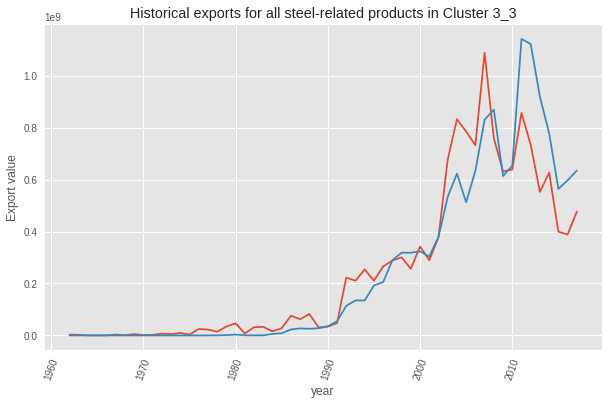

<Figure size 720x396 with 0 Axes>

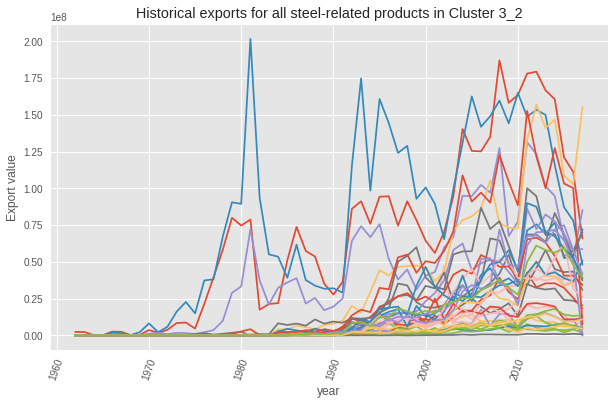

<Figure size 720x396 with 0 Axes>

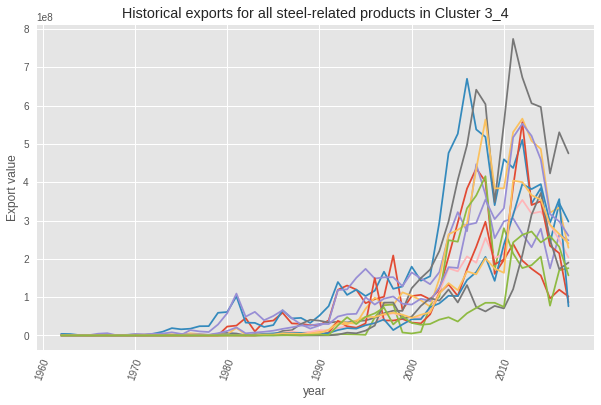

<Figure size 720x396 with 0 Axes>

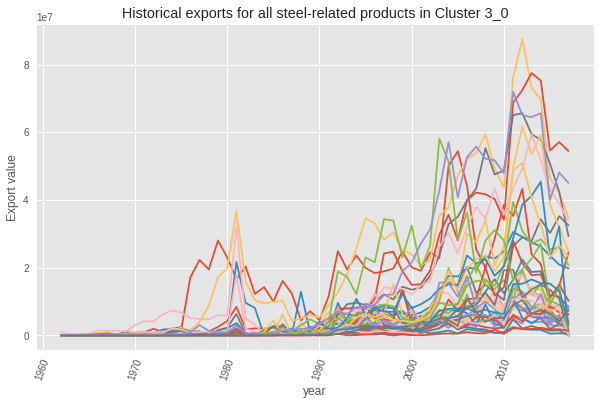

<Figure size 720x396 with 0 Axes>

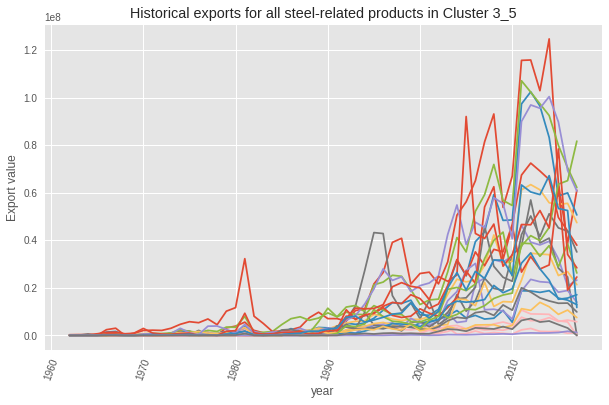

In [293]:
# Plots for country comparison per product 
for c in country_cluster.cluster.unique():
  cluster = country_cluster[country_cluster.cluster==c]
  country_list = cluster['names'].unique()
  product = pd.pivot_table(trade_dframe,index='year',columns='zaf_code',
                           values='export_val',aggfunc=np.mean)
  df = product[country_list]
  df.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  df.plot(subplots=False,figsize=(10,6),legend=False,
                            title=(f"Historical exports for all steel-related products in Cluster 3_{c}"))
  plt.xticks(rotation=70)
  # plt.legend()
  plt.ylabel("Export value")
  plt.savefig(f"{image_dump}/products_in_cluster_3_{c}")
  plt.show()